In [1]:
import sys, os, time, shutil, random
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from scipy import misc, signal

import torch
from torch.nn import functional as F

from sklearn.neighbors import NearestNeighbors
import networkx as nx
import cv2
import random
import ctypes
from scipy.signal import convolve2d, correlate2d
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import Counter
import io

from omnibelt import load_yaml, save_yaml, multi_index

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import *
from skimage.segmentation import watershed, expand_labels
from skimage.morphology import closing, square, dilation
from skimage.color import label2rgb
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [21]:
root = Path('extra/wd/step1')

In [41]:
rgba = Image.open(root/'wd_color.png').convert('RGBA')
rgba = np.asarray(rgba)
rgb = rgba[...,:3]
lbls = np.array(Image.open(root/'regions.png'))
lbls.shape, rgb.shape

((2232, 5988), (2232, 5988, 3))

In [42]:
def showx(im, cover=lbls):
    plt.figure(figsize=(20,10))
    try:
        plt.imshow(im.astype(int))
        if cover is not None:
            plt.imshow(cover%1000, alpha=0., zorder=10)
    except ValueError:
        plt.imshow(im)
    
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)
    
def highlight(rgb, mask, opacity=0.2):
    alpha = np.zeros_like(mask).astype(np.uint8)
    
    img = rgb.astype(np.uint8)
    
    alpha[mask!=0] = 255
    alpha[mask==0] = int(255*opacity)
    
    H,W,C = img.shape
    
    if C == 4:
        img[...,-1] = alpha
    else:
        img = np.concatenate([img, alpha.reshape(H,W,1)],-1)
    return showx(img)
    
# showx(lbls)

In [43]:
nodes = load_yaml(root/'graph.yaml')
len(nodes)

781

In [44]:
filled = expand_labels(lbls,100)
(filled==0).sum()

0

In [45]:
borders = find_boundaries(filled, mode='thick')
# showx(borders)

In [46]:
clean = filled.copy()
clean[borders==1] = 0
# showx(clean)

In [47]:
# Image.fromarray(clean.astype(np.int16)).save(root / "clean.png")
# Image.fromarray(((clean!=0)*255).astype(np.uint8)).save(root / "borders.png")

In [48]:
cnts = Counter(clean.reshape(-1))
len(cnts)

787

In [49]:
colors = {node['ID']: Counter(map(tuple, rgb[node['ID']==lbls].tolist())) for node in tqdm(nodes)}
len(colors)

  0%|          | 0/781 [00:00<?, ?it/s]

781

In [50]:
{k:v for k,v in colors.items() if len(v)>1}

{}

In [40]:
# highlight(rgb,expand_labels(lbls==776,10))

# Region Types

<IPython.core.display.Javascript object>


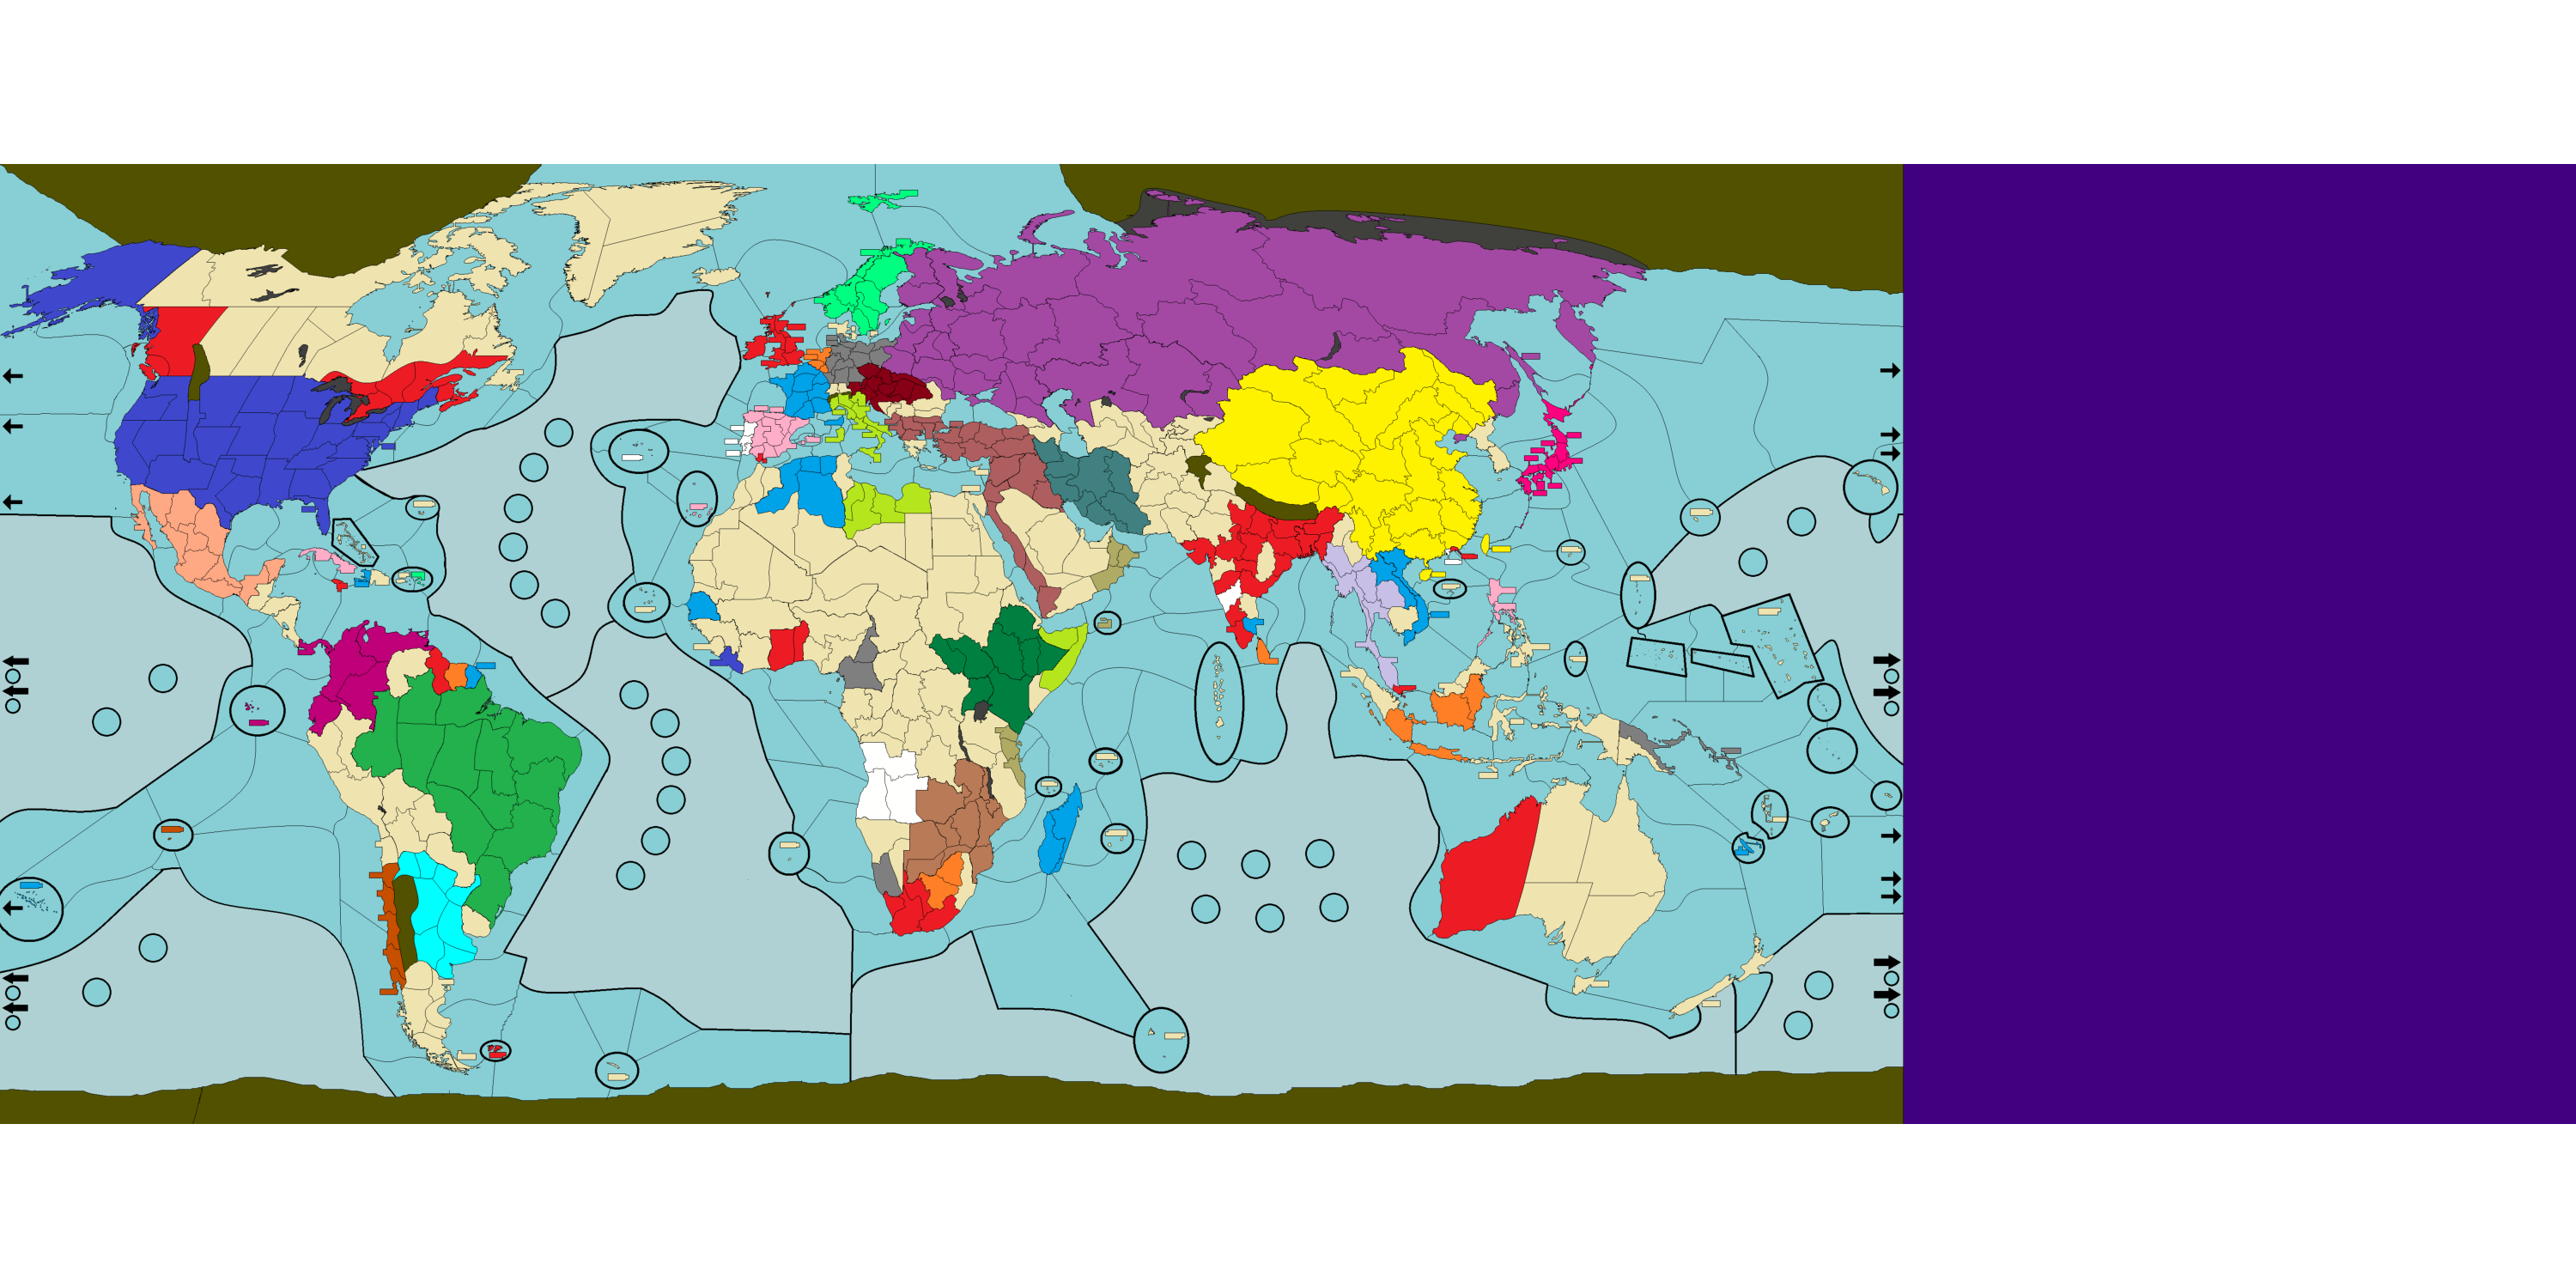

In [51]:
showx(rgb,cover=None)

In [52]:
sea_colors = {(135,207,213), (175,209,211)}

In [53]:
for node in nodes:
    c = list(colors[node['ID']].keys())[0]
    node['type'] = 'sea' if c in sea_colors else 'land'

In [54]:
node

{'ID': 781, 'name': 'PR-water', 'tiles': [1036], 'type': 'sea'}